In [1]:
import numpy as np
import qiskit as qk
import math
from qiskit import Aer
import os


from calibration_functions import *  
# Functions:
# get_readout_err(experimental_backend, number_of_shots)      find calibrating matrix B 
# calibrate_readout_err(exper_expect_val , B)       find calibrated exp_value vector

from transfer_matrix_tools import *
# Functions:
# calculate_gate_fidelity(n, Transfer_matrix_ideal,Transfer_matrix)     n=number f qubits
# calculate_transfer_matrix(input_expected_values,output_expected_values)
# plot_transfer_matrix(Transfer_matrix)

from theoretical_tools import *
# Functions:
# exp_value_braket(statevector,operator)

from backend_tools import *
# Functions:
# IBM_backend('ibm_backend')
# QI_backend('qi_backend' )
# simulator_backend()
# noisy_simulator_backend()

In [4]:
#BACKEND AND NUMBER OF SHOTS

experimental_backend = noisy_simulator_backend()
number_of_shots = 8192
experiment_name='rx_pi_3_simulation'

In [5]:
states = [np.array([1,0]),np.array([0,1]),1/np.sqrt(2) * np.array([1,1]), \
          1/np.sqrt(2) * np.array([1,-1]), 1/np.sqrt(2) * np.array([1, complex(0,1)]), 1/np.sqrt(2) * np.array([1, complex(0,-1)])]
possible_directions = ['I', 'X','Y', 'Z']


experiment_directory=os.path.join('data_collected', experiment_name)

#if the folder does not exist, create it
if not os.path.exists(experiment_directory):
    os.makedirs(experiment_directory)


#PAULI GATES
pauli_g=np.zeros((4,2,2),dtype = np.complex_)
pauli_g[0] = np.array([[1,0],[0,1]]) 
pauli_g[1] = np.array([[0,1],[1,0]]) 
pauli_g[2] = np.array([[0,complex(0,-1)],[complex(0,1),0]]) 
pauli_g[3] = np.array([[1,0],[0,-1]])

sv_backend = Aer.get_backend('statevector_simulator') #statevector for theoretical transfer matrix


#get calibration data

B=get_readout_err(experimental_backend, 8192)

np.save( os.path.join(experiment_directory, 'B'), B )



sv_expected_values=np.zeros((6, 4))
precalibration_exp_values=np.zeros((6, 4))
output_expected_values = np.zeros((6, 4))
input_expected_values = np.zeros((6, 4))


m=0                      # goes from 0 to 6 (6 cardinal states)
for state1 in states:
    d1d2=0           #   
    n=0              #  
    d2=0             #direction 2  (the only direction) numbering
    for direction2 in possible_directions:
        
        
        input_state_vector=state1
        
        input_expected_values[m,d1d2]=  exp_value_braket(input_state_vector, pauli_g[d2] )    # <'Direction2' 'Direction1'> =  <bra| D2D1_matrix   |ket> 
    

        

        if direction2 == 'I' : # For the I case we don't need a circuit
            output_expected_values[m,0] = 1
            precalibration_exp_values[m,0] = 1
            sv_expected_values[m,0]=1
            d2+=1
            d1d2+=1
            continue  
        #print("Let's find the expectation value for the", direction1, direction2, 'measurements')
        
        # Define circuit
        q = qk.QuantumRegister(1)
        c = qk.ClassicalRegister(1)
        circuit = qk.QuantumCircuit(q, c)
        
        # Do some initialization for the input states
        circuit.initialize(state1, 0)  # Initialize the 0th qubit using a complex vector
            

                   #INPUT PROCESS
                        
        # The gates for the process
        
        circuit.rx(math.pi/3,q[0])



        ## statevector simulator for theoretical output    
        sv_job = qk.execute(circuit, sv_backend)
        sv_result = sv_job.result()
        sv_output = sv_result.get_statevector(circuit, decimals=3)

        sv_expected_values[m,d1d2]  =  exp_value_braket(sv_output, pauli_g[d2] ) 


        d1d2+=1  #iterating d1d2 used for theoretical exp values
        


        #EXPERIMENT ON THE BACKEND FROM NOW ON

        # Rotate to make measurements in different bases // go on to experiment only if neither direction is I 


        if direction2 == 'X' : 
            circuit.ry(-math.pi/2, q[0])
        elif direction2 == 'Y' : 
            circuit.rx(math.pi/2, q[0])


        circuit.measure(q, c)    # Measure both bits

        # Define the experiment


        experimental_job = qk.execute(circuit, backend=experimental_backend, shots=number_of_shots)
        experimental_result = experimental_job.result()

        # Look at the results
        histogram = experimental_result.get_counts(circuit)
        
        # Add the results to the results matrix
        expected_value=0
        for state, counts in histogram.items() :           
            expected_value += (-1)**(int(state[0]))*int(counts)    #corresponds to ZI               


        expected_value = expected_value / number_of_shots

        calibrated_exp_val=calibrate_readout_err(expected_value,B)
    


        ## Calculation of <U>  
        output_expected_values[ m ,d2] = calibrated_exp_val
        precalibration_exp_values[ m ,d2] = expected_value
        


        #save data
        np.save(os.path.join(experiment_directory, 'output_expected_values')     ,output_expected_values)
        np.save(os.path.join(experiment_directory, 'precalibration_exp_values')  ,precalibration_exp_values)
        np.save(os.path.join(experiment_directory, 'sv_expected_values' )        ,sv_expected_values)
        np.save(os.path.join(experiment_directory, 'input_expected_values')      ,input_expected_values)

        print(' m = ',m,' n = ',n)
        n += 1
        d2+=1

    m += 1

print('Experiment Completed!')

Calibration has begun.

Calibration done!

 m =  0  n =  0
 m =  0  n =  1
 m =  0  n =  2
 m =  1  n =  0
 m =  1  n =  1
 m =  1  n =  2
 m =  2  n =  0
 m =  2  n =  1
 m =  2  n =  2
 m =  3  n =  0
 m =  3  n =  1
 m =  3  n =  2
 m =  4  n =  0
 m =  4  n =  1
 m =  4  n =  2
 m =  5  n =  0
 m =  5  n =  1
 m =  5  n =  2
Experiment Completed!


In [6]:
#ACCESS DATA AND GET RESULTS


experiment_name='identity_simulation' #  INPUT EXPERIMENTAL IDENTITY
experiment_directory=os.path.join('data_collected', experiment_name)
exp_input_expected_values= np.load(os.path.join(experiment_directory, 'output_expected_values.npy') )

experiment_name='rx_pi_3_simulation'  #  EXPERIMENTAL OUTPUT
experiment_directory=os.path.join('data_collected', experiment_name)
B                    =np.load(os.path.join(experiment_directory, 'B.npy') ) 
input_expected_values=np.load(os.path.join(experiment_directory, 'input_expected_values.npy') )
precalibration_exp_values=np.load(os.path.join(experiment_directory, 'precalibration_exp_values.npy') )
sv_expected_values=np.load(os.path.join(experiment_directory, 'sv_expected_values.npy') )
output_expected_values=np.load(os.path.join(experiment_directory, 'output_expected_values.npy') )



th_transfer_matrix = calculate_transfer_matrix( input_expected_values, sv_expected_values ) 
exp_transfer_matrix = calculate_transfer_matrix( input_expected_values, output_expected_values )  #experimental output with ideal input

exp_inp_transfer_matrix = calculate_transfer_matrix( exp_input_expected_values , output_expected_values )  #experimental output with experimental input

In [13]:
#average gate fidelity
calculate_gate_fidelity(1, th_transfer_matrix , exp_inp_transfer_matrix)

1.001196538577821

In [14]:
#error through bootstrapping
get_bootstrap_standard_error(1 , 8192 , 1000 , input_expected_values , output_expected_values , sv_expected_values,exp_input_expected_values)

0.003321429412814527

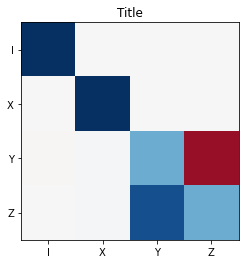

In [15]:
plot_transfer_matrix(exp_inp_transfer_matrix,'Title')